## Q5
Complete the f objective function in the skeleton code, which computes the objective function for Jlogistic(w). (Hint: you may get numerical overflow when computing the exponential literally, e.g. try e1000 in Numpy. Make sure to read about the log-sum-exp trick and use the numpy function logaddexp to get accurate calculations and to prevent overflow.

In [1]:
# numerical overflow check
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.exp(1000)

<ipython-input-1-f582a92b4683>:6: RuntimeWarning: overflow encountered in exp
  np.exp(1000)


inf

In [2]:
def f_objective(theta, X, y, l2_param=1):
    '''
    Args:
        theta: 1D numpy array of size num_features
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
        l2_param: regularization parameter

    Returns:
        objective: scalar value of objective function
    '''
    
    # objective function = avg loss + reg term
    # avg_loss
    avg_loss = (1/X.shape[0]) * sum(np.logaddexp(0, -y*(X @ theta.T )))
    
    # reg term
    l2_reg = l2_param * (theta @ theta.T)             
    
    # return scalar value of objective function
    objective = avg_loss + l2_reg
    
    return objective

## Q6
Complete the fit logistic regression function in the skeleton code using the minimize function from scipy.optimize. Use this function to train a model on the provided data. Make sure to take the appropriate preprocessing steps, such as standardizing the data and adding a column for the bias term.

In [3]:
from scipy.optimize import minimize

def fit_logistic_reg(X, y, objective_function, l2_param=1):
    '''
    Args:
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
        objective_function: function returning the value of the objective
        l2_param: regularization parameter
        
    Returns:
        optimal_theta: 1D numpy array of size num_features
    '''
    
    # initialize optimal theta
    optimal_theta = np.zeros(X.shape[1])
    
    # update optimal theta by using minimize function                          
    optimal_theta = minimize(objective_function, optimal_theta, args = (X, y, l2_param)).x
    
    return optimal_theta

In [4]:
# preprocessing steps: Source from HW2 code 
def feature_normalization(train, test):
    
    # discard features that are constant in the training set
    remove = []
    for i in range(train.shape[1]):
        if len(set(train[:, i])) == 1:
            remove.append(i)
    for i in remove:
        np.delete(train, i, axis=1)
        np.delete(test, i, axis=1)
    
    # min-max scaling
    train_normalized = np.array(train.shape)
    test_normalized = np.array(test.shape)
    train_max_vals = np.max(train, axis=0)
    train_min_vals = np.min(train, axis=0)
    
    # use train min-max to transform both train/test dataset
    train_normalized = (train - train_min_vals) / (train_max_vals - train_min_vals)
    test_normalized = (test - train_min_vals) / (train_max_vals - train_min_vals)
    
    return train_normalized, test_normalized

In [5]:
# import txt files
X_train = np.loadtxt('./X_train.txt', delimiter = ',')
y_train = np.loadtxt('./y_train.txt', delimiter = ',')
X_val = np.loadtxt('./X_val.txt', delimiter = ',')
y_val = np.loadtxt('./y_val.txt', delimiter = ',')

In [6]:
# standardizing the data 
X_train_normalized, X_val_normalized = feature_normalization(X_train, X_val)

In [7]:
# adding a column for the bias term
X_train_normalized = np.hstack((X_train_normalized, np.ones((X_train_normalized.shape[0], 1))))
X_val_normalized = np.hstack((X_val_normalized, np.ones((X_val_normalized.shape[0], 1))))

In [8]:
# as we assume outcome space Y± = {−1, 1}, convert y = 0 values into -1
y_train[y_train == 0] = -1
y_val[y_val == 0] = -1

In [9]:
# Train model
# we need to define f_objective 
optimal_theta = fit_logistic_reg(X_train_normalized, y_train, f_objective, l2_param=1)
optimal_theta

array([ 0.00098731,  0.00086963,  0.00030947,  0.02207394,  0.00024183,
        0.00074032,  0.00011989,  0.00085942,  0.00090577, -0.01224866,
        0.0019563 ,  0.000236  ,  0.00459849,  0.00012707,  0.00047895,
        0.00117241,  0.00037255, -0.00044841, -0.00044868, -0.00069619,
        0.00178106])

## Q7
Find the l2 regularization parameter that minimizes the log-likelihood on the validation set.  
Plot the log-likelihood for different values of the regularization parameter.

Best l2 param:0.001, NLL: -233.41486969339837


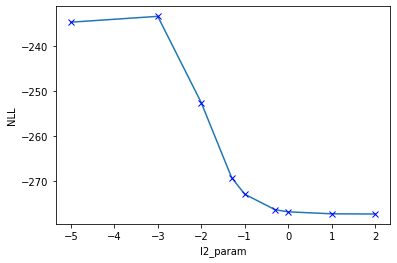

In [56]:
import matplotlib.pyplot as plt

def neg_log_likelihood(theta, X, y, l2_param):
    
    # From Q1, we know that n*Rn(w) = NLL(w), in terms of w 
    # avg_loss
    avg_loss = (1/X.shape[0]) * sum(np.logaddexp(0, -y*(X @ theta.T )))       
    
    # return scalar value of objective function
    objective = avg_loss
    
    # multiplying by n and return
    return -1*X.shape[0] * objective

# creating nll empty set, and l2 param range
NLL_res = []
l2_param_range = np.arange(0.000001, 0.3, 0.0001)
# l2_param_range = [1e-05, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100]

# for given l2 param range, calculate theta
for l2_param in l2_param_range:
    optimal_theta = fit_logistic_reg(X_train_normalized, y_train, f_objective, l2_param)
    NLL_res.append(neg_log_likelihood(optimal_theta, X_val_normalized, y_val, l2_param))

# plotting the answers   
# print(l2_param_range, NLL_res)
print('Best l2 param:{}, NLL: {}'.format(l2_param_range[np.argmax(NLL_res)], np.max(NLL_res)))
plt.plot(np.log10(l2_param_range), NLL_res)
plt.plot(np.log10(l2_param_range), NLL_res, 'bx')
plt.xlabel('l2_param')
plt.ylabel('NLL')
plt.show()

## Q8
[Optional]It seems reasonable to interpret the predictionf(x)=φ(wTx)=1/(1+e−wTx) as the probability that y = 1, for a randomly drawn pair (x, y). Since we only have a finite sample (and we are regularizing, which will bias things a bit) there is a question of how well “calibrated” our predicted probabilities are. Roughly speaking, we say f(x) is well calibrated if we look at all examples (x,y) for which f(x) ≈ 0.7 and we find that close to 70% of those examples have y = 1, as predicted... and then we repeat that for all predicted probabilities in (0, 1). To see how well-calibrated our predicted probabilities are, break the predictions on the validation set into groups based on the predicted probability (you can play with the size of the groups to get a result you think is informative). For each group, examine the percentage of positive labels. You can make a table or graph. Summarize the results. You may get some ideas and references from scikit-learn’s discussion.

### Ans) LogisticRegression returns well calibrated predictions by default as it directly optimizes Log loss

In [11]:
# Best l2 param: 0.000501
from sklearn.calibration import calibration_curve

optimal_theta = fit_logistic_reg(X_train_normalized, y_train, f_objective, l2_param = 0.000501)
y_pred = 1/(1+np.exp(-(X_val_normalized @ optimal_theta.T)))

prob_true, prob_pred = calibration_curve(y_val, y_pred, normalize=False, n_bins=10)

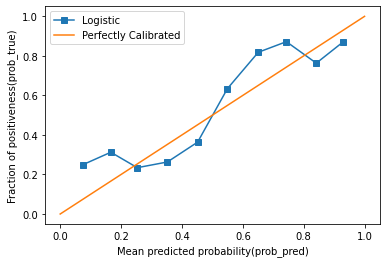

In [12]:
plt.plot(prob_pred, prob_true, marker = 's', label = 'Logistic')
plt.plot([0, 1], [0, 1], label = 'Perfectly Calibrated')
plt.xlabel('Mean predicted probability(prob_pred)')
plt.ylabel('Fraction of positiveness(prob_true)')
plt.legend()
plt.show()

### The percentage of positive labels for each group

In [13]:
# The percentage of positive labels for each group
for idx, value in enumerate(prob_true):
    print('Group {}) Percentage of positive labels: {:.2f}'.format(idx+1, value))

Group 1) Percentage of positive labels: 0.25
Group 2) Percentage of positive labels: 0.31
Group 3) Percentage of positive labels: 0.23
Group 4) Percentage of positive labels: 0.26
Group 5) Percentage of positive labels: 0.36
Group 6) Percentage of positive labels: 0.63
Group 7) Percentage of positive labels: 0.82
Group 8) Percentage of positive labels: 0.87
Group 9) Percentage of positive labels: 0.76
Group 10) Percentage of positive labels: 0.87
